In [28]:
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=10):
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)
        self.hid_2mu = nn.Linear(h_dim, z_dim)
        self.hid_2sigma = nn.Linear(h_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)
        self.hid_2img = nn.Linear(h_dim, input_dim)

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))

    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma


if __name__ == "__main__":

    # Configuration
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    INPUT_DIM = 784
    H_DIM = 200
    Z_DIM = 20
    NUM_EPOCHS = 20
    # BATCH_SIZE = 32
    LR_RATE = 3e-4  # Karpathy constant
    BETA_VALUE = 4

    # Dataset Loading
    # dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
    # train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    fdataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(fdataset, batch_size=32, shuffle=True, num_workers=4)

    images, labels = next(iter(train_loader))
    print(f"{images.shape=} {labels.shape=}")

    model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
    loss_fn = nn.BCELoss(reduction="sum")

    for epoch in range(NUM_EPOCHS):
        loop = tqdm(enumerate(train_loader))
        for i, (x, y) in loop:
            x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
            x_reconstructed, mu, sigma = model(x)

            reconstruction_loss = loss_fn(x_reconstructed, x)
            kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            loss = reconstruction_loss + BETA_VALUE * kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss = loss.item())

images.shape=torch.Size([32, 1, 28, 28]) labels.shape=torch.Size([32])


1875it [00:27, 68.69it/s, loss=-7.24e+5]
1875it [00:26, 70.47it/s, loss=-8.73e+5]
1875it [00:27, 69.37it/s, loss=-1.01e+6]
1875it [00:26, 71.66it/s, loss=-1.04e+6]
1875it [00:27, 67.02it/s, loss=-1.15e+6]
1875it [00:27, 68.11it/s, loss=-1.2e+6]
1875it [00:28, 66.93it/s, loss=-1.13e+6]
1875it [00:27, 69.23it/s, loss=-1.21e+6]
1875it [00:28, 65.01it/s, loss=-1.33e+6]
1875it [00:28, 66.88it/s, loss=-1.38e+6]
1875it [00:28, 66.55it/s, loss=-1.29e+6]
1875it [00:28, 65.95it/s, loss=-1.34e+6]
1875it [00:27, 68.05it/s, loss=-1.36e+6]
1875it [00:26, 70.25it/s, loss=-1.34e+6]
1875it [00:27, 69.11it/s, loss=-1.36e+6]
1875it [00:27, 69.14it/s, loss=-1.3e+6]
1875it [00:26, 70.27it/s, loss=-1.23e+6]
1875it [00:28, 66.86it/s, loss=-1.15e+6]
1875it [00:26, 70.31it/s, loss=-1.38e+6]
1875it [00:27, 68.92it/s, loss=-1.19e+6]


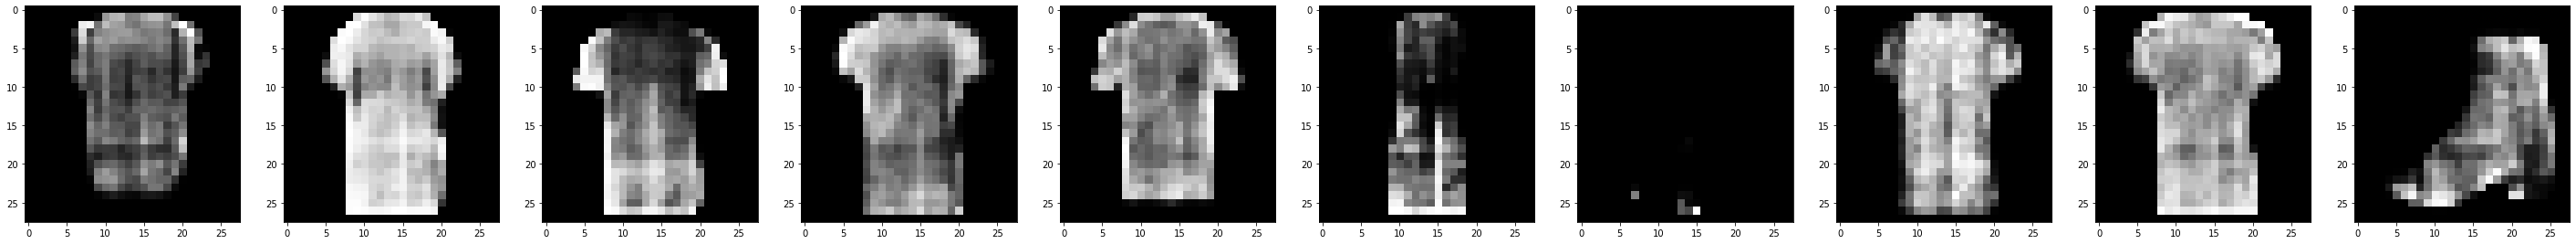

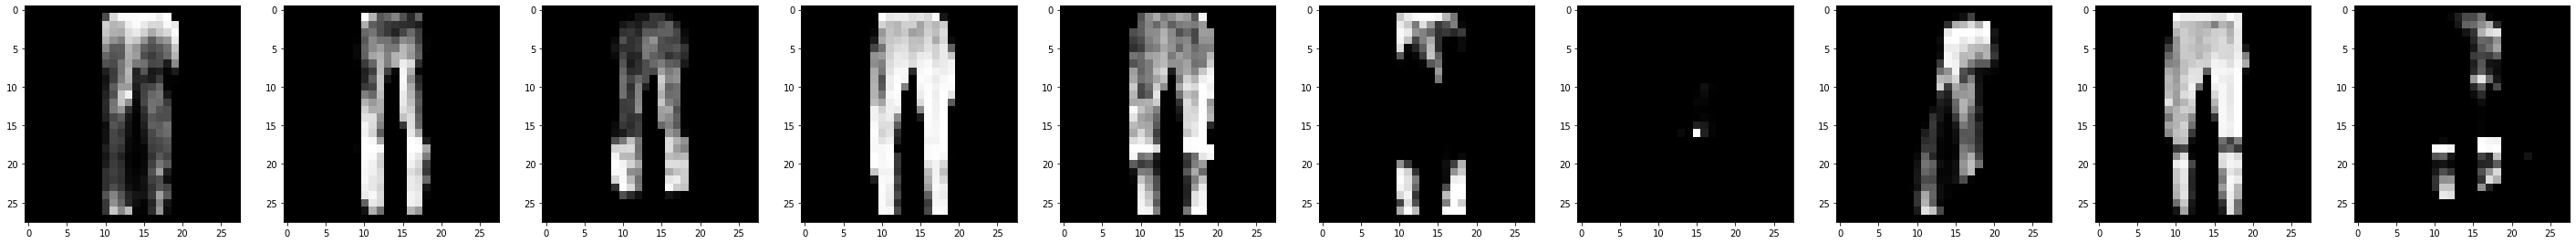

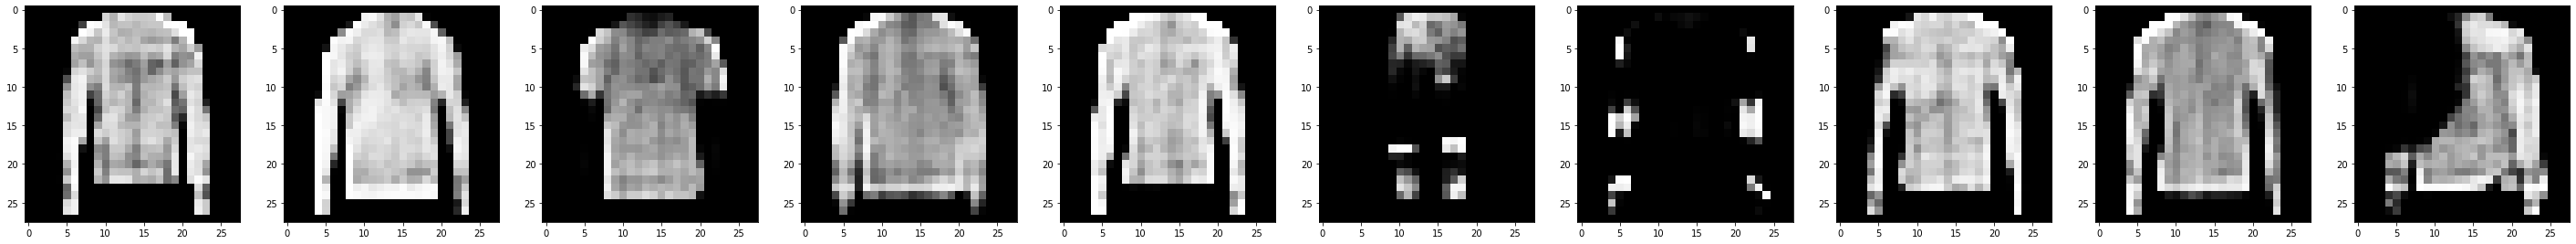

In [34]:
from matplotlib import pyplot as plt
from matplotlib import cm

def inference(class_val, num_examples):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.
    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in fdataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].to(DEVICE).view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[class_val]
    fig, axis = plt.subplots(1, 10, figsize = (50, 50))
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        z[0][example] += 10
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated_{class_val}_ex{example}.png")
        out = torch.squeeze(out)
        axis[example].imshow(out.to('cpu').detach().numpy(), cmap = 'gray')
    plt.show()

for idx in range(3):
    inference(idx, num_examples=10)